In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import gpytorch
from gpytorch import means, kernels, likelihoods, distributions, lazy
import matplotlib.pyplot as plt
import xarray as xr
from fair.defaults import thermal
import fair_utils
import tqdm

In [3]:
# Load scenarios for training
inputs_ssp126 = xr.open_dataset('../data/inputs_ssp126.nc').compute()
inputs_ssp370 = xr.open_dataset('../data/inputs_ssp370.nc').compute()
inputs_ssp585 = xr.open_dataset('../data/inputs_ssp585.nc').compute()
inputs_histGHG = xr.open_dataset('../data/inputs_hist-GHG.nc').compute()
inputs_train = [inputs_ssp126, inputs_ssp370, inputs_ssp585, inputs_histGHG]

output_ssp126 = xr.open_dataset('../data/outputs_ssp126.nc').compute()
output_ssp370 = xr.open_dataset('../data/outputs_ssp370.nc').compute()
output_ssp585 = xr.open_dataset('../data/outputs_ssp585.nc').compute()
output_histGHG = xr.open_dataset('../data/outputs_hist-GHG.nc').compute()
outputs_train = [output_ssp126, output_ssp370, output_ssp585, output_histGHG]

# Load another one for testing
inputs_ssp245 = xr.open_dataset('../data/inputs_ssp245.nc').compute()
outputs_ssp245 = xr.open_dataset('../data/outputs_ssp245.nc').compute()

# Extrat CO2 and temperature anomaly arrays
def extract_arrays(xr_input, xr_output):
    time = xr_input.time.values
    cum_emissions = xr_input.CO2.values
    emissions = np.append(np.diff(cum_emissions)[0], np.diff(cum_emissions))
    weights = np.cos(np.deg2rad(xr_output.lat))
    tas = xr_output.tas.weighted(weights).mean(['lat', 'lon', 'member']).data
    return time, cum_emissions, emissions, tas

time_train = []
cum_emissions_train = []
emissions_train = []
tas_train = []
for xr_input, xr_output in zip(inputs_train, outputs_train):
    time, cum_emissions, emissions, tas = extract_arrays(xr_input, xr_output)
    time_train.append(time)
    cum_emissions_train.append(cum_emissions)
    emissions_train.append(emissions)
    tas_train.append(tas)
time_test, cum_emissions_test, emissions_test, tas_test = extract_arrays(inputs_ssp245, outputs_ssp245)

In [49]:
# Run FaIR to obtain forcings vectors
F_train = []
tas_fair_train = []
for emissions in emissions_train:
    _, F, tas_fair = fair_utils.fair_scm(emissions=emissions, other_rf=0)
    F_train.append(F)
    tas_fair_train.append(tas_fair)
_, F_test, tas_fair_test = fair_utils.fair_scm(emissions=emissions_test, other_rf=0)

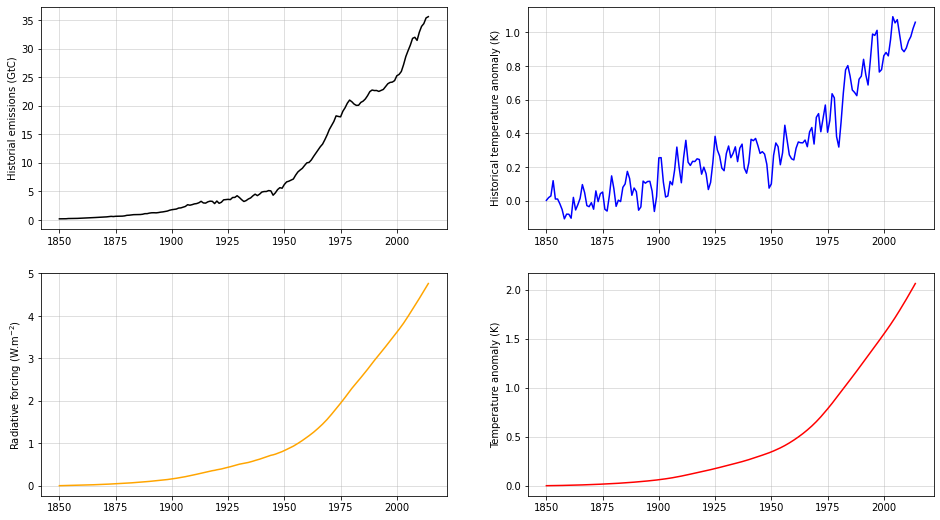

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].plot(time_train[3], emissions_train[3], color='black')
ax[0, 0].set_ylabel('Historial emissions (GtC)')
ax[0, 0].grid(alpha=0.5)

ax[0, 1].plot(time_train[3], tas_train[3], color='blue')
ax[0, 1].set_ylabel('Historical temperature anomaly (K)')
ax[0, 1].grid(alpha=0.5)

ax[1, 0].plot(time_train[3], F_train[3], color='orange')
ax[1, 0].set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax[1, 0].grid(alpha=0.5)

ax[1, 1].plot(time_train[3], tas_fair_train[3], color='red')
ax[1, 1].set_ylabel('Temperature anomaly (K)')
ax[1, 1].grid(alpha=0.5)
plt.show()

In [7]:
def get_ξ_from_forcing(q, d, F):
    # Taken straight from FaIR codebase, not sure why computed this way
    ξ = np.zeros((len(F), len(d)))
    ξ[0] = (q[0] / d) * F[0]
    ξ[1:] = q * (1 - np.exp(-1 / d)) * F[1:, None]
    return ξ

In [51]:
# Prepare tensors
Xtrain = torch.from_numpy(np.concatenate(cum_emissions_train)).float()
ytrain = torch.from_numpy(np.concatenate(tas_train)).float()
ξ_train = torch.from_numpy(get_ξ_from_forcing(thermal.q, thermal.d, np.concatenate(F_train)))

Xtest = torch.from_numpy(cum_emissions_test).float()
ytest = torch.from_numpy(tas_test).float()
ξ_test = torch.from_numpy(get_ξ_from_forcing(thermal.q, thermal.d, F_test))

In [52]:
# Standardize inputs
mux, sigmax = Xtrain.mean(), Xtrain.std()
Xtrain_std = (Xtrain - mux) / sigmax
Xtest_std = (Xtest - mux) / sigmax

In [53]:
class ThermalBoxesGP(gpytorch.models.ExactGP):
    def __init__(self, X, y, means, kernels, d, ξ, likelihood):
        X = torch.cat([X.view(-1, 1), ξ], dim=-1)
        super(ThermalBoxesGP, self).__init__(X, y, likelihood)
        self.means = torch.nn.ModuleList(means)
        self.kernels = torch.nn.ModuleList(kernels)
        self.d = torch.from_numpy(d)
        self.ξ = ξ
        self.nboxes = len(d)

    def forward_box(self, x, idx):
        ξ = x[..., -self.nboxes:]
        x = x[..., :-self.nboxes]
        mean_box = torch.exp(-1. / self.d[idx]) * self.means[idx](x) + ξ[:, idx]
        covar_box = torch.exp(-2. / self.d[idx]) * self.kernels[idx](x)
        return mean_box, covar_box

    def forward(self, x):
        mean_x = []
        covar_x = []
        for idx in range(self.nboxes):
            mean_box, covar_box = self.forward_box(x, idx)
            mean_x.append(mean_box)
            covar_x.append(covar_box)
        mean_x = torch.stack(mean_x).sum(dim=0)
        covar_x = lazy.SumLazyTensor(*covar_x)
        return distributions.MultivariateNormal(mean_x, covar_x)

In [54]:
# Define thermal boxes GPs
m1 = means.ZeroMean()
m2 = means.ZeroMean()
k1 = kernels.RBFKernel()
k2 = kernels.RBFKernel()
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesGP(Xtrain_std, ytrain, [m1, m2], [k1, k2], thermal.d, ξ_train, likelihood)

In [55]:
# Find optimal model hyperparameters
model.train()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
n_iter = 200
training_iter = tqdm.notebook.tqdm(range(n_iter), desc='Iter')

for i in training_iter:
    optimizer.zero_grad()
    output = model(model.train_inputs[0])
    loss = -mll(output, ytrain)
    loss.backward()
    optimizer.step()
    training_iter.set_postfix_str(f"LL = {-loss.item()}")

In [56]:
model.eval()
with torch.no_grad():
    test_inputs = torch.cat([Xtest_std.view(-1, 1), ξ_test], dim=-1)
    pred = model(test_inputs)
    noisy_pred = model.likelihood(pred)

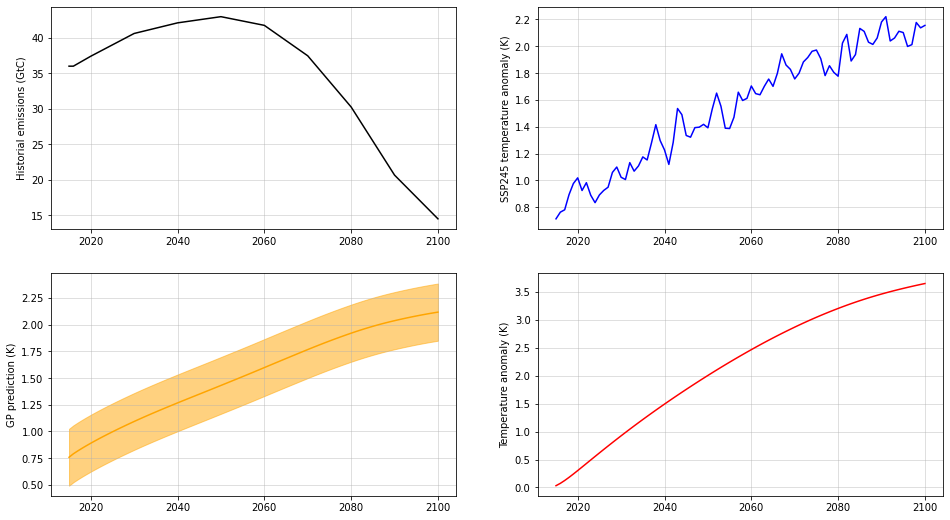

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].plot(time_test, emissions_test, color='black')
ax[0, 0].set_ylabel('Historial emissions (GtC)')
ax[0, 0].grid(alpha=0.5)

ax[0, 1].plot(time_test, tas_test, color='blue')
ax[0, 1].set_ylabel('SSP245 temperature anomaly (K)')
ax[0, 1].grid(alpha=0.5)

lb, ub = noisy_pred.confidence_region()
ax[1, 0].plot(time_test, pred.mean, color='orange')
ax[1, 0].fill_between(time_test, lb, ub, alpha=0.5, color='orange')
ax[1, 0].set_ylabel('GP prediction (K)')
ax[1, 0].grid(alpha=0.5)

ax[1, 1].plot(time_test, tas_fair_test, color='red')
ax[1, 1].set_ylabel('Temperature anomaly (K)')
ax[1, 1].grid(alpha=0.5)
plt.show()

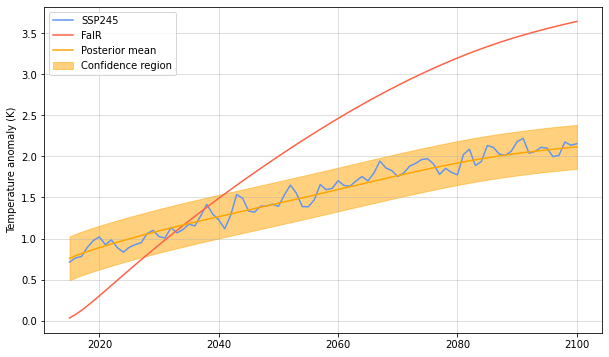

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

lb, ub = noisy_pred.confidence_region()

ax.plot(time_test, tas_test, color='cornflowerblue', label='SSP245')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(time_test, tas_fair_test, color='tomato', label='FaIR')
ax.plot(time_test, pred.mean, color='orange', label='Posterior mean')
ax.fill_between(time_test, lb, ub, alpha=0.5, color='orange', label='Confidence region')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

In [63]:
rmse = torch.sqrt(torch.square(pred.mean - tas_test).mean()).item()
ll = noisy_pred.log_prob(torch.from_numpy(tas_test)).item()

print("RMSE = ", rmse)
print("LL = ", ll)

RMSE =  0.09044467479358005
LL =  75.38517504818971
